In [1]:
!pip install torch torchvision

  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [0]:
#@title Importing libraries...
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objs as go
import plotly

%matplotlib inline

import numpy as np

from google.colab import files
import pickle as pk

from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import MNIST
#from torchvision.datasets import MNIST

from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

cuda:0


In [0]:
#@title Loading dataset
trainset = MNIST(root='./dataMNIST/',
                 train=True,
                 transform=transforms.ToTensor(),
                 download=True)
testset = MNIST(root='./dataMNIST/',
                train=False,
                transform=transforms.ToTensor(),
                download=True)
labels = ['#0','#1','#2','#3','#4','#5','#6','#7','#8','#9']

N_train = len(trainset)
N_test = len(testset)

batch=128

train_loader = DataLoader(dataset=trainset,
                          batch_size=batch,
                          shuffle=True)

test_loader = DataLoader(dataset=testset,
                         batch_size=batch,
                         shuffle=False)

Processing...
Done!


In [0]:
#@title Establishing architecture
class AE(nn.Module):
  def __init__(self):
    super(AE,self).__init__()
    
    self.act   = nn.LeakyReLU()
    self.tanh  = nn.Tanh()
    
    self.z_dim = 32
    
    self.enc1  = nn.Conv2d(1,128,5,padding=2,stride=2)
    self.enc1s = nn.Sequential(nn.BatchNorm2d(128),\
                               self.act)
    
    self.enc2  = nn.Conv2d(128,256,5,padding=2,stride=2)
    self.enc2s = nn.Sequential(nn.BatchNorm2d(256),\
                               self.act)
    
    self.enc3  = nn.Linear(7*7*256,1024)
    self.enc3s = nn.Sequential(nn.BatchNorm1d(1024),\
                               self.act)
    
    self.enc4  = nn.Linear(1024,128)
    self.enc4s = nn.Sequential(nn.BatchNorm1d(128),\
                               self.act)
    
    self.logvar = nn.Linear(128,self.z_dim)
    
    self.mu    = nn.Linear(128, self.z_dim)
    
    self.dec1  = nn.Linear(self.z_dim,128)
    self.dec1s = nn.Sequential(nn.BatchNorm1d(128),\
                               self.act)
    
    self.dec2  = nn.Linear(128,1024)
    self.dec2s = nn.Sequential(nn.BatchNorm1d(1024),\
                               self.act)
    
    self.dec3  = nn.Linear(1024,7*7*256)
    self.dec3s = nn.Sequential(nn.BatchNorm1d(7*7*256),\
                               self.act)
    
    self.dec4  = nn.ConvTranspose2d(256,128,5,stride=2,padding=2)
    self.dec4s = nn.Sequential(nn.BatchNorm2d(128),\
                               self.act)
    
    self.dec5  = nn.ConvTranspose2d(128,1,5,stride=2,padding=2)
    self.dec5s = nn.Sequential(nn.BatchNorm2d(1),\
                               self.act)
    
    self.dec6  = nn.ConvTranspose2d(1,1,4,stride=1,padding=0)
    self.dec6s = nn.Sequential(nn.BatchNorm2d(1),\
                               nn.Sigmoid())
    
    #nn.init.xavier_normal_(self.enc1.weight.data)
    #nn.init.xavier_normal_(self.enc2.weight.data)
    #nn.init.xavier_normal_(self.enc3.weight.data)
    #nn.init.xavier_normal_(self.enc4.weight.data)
    #nn.init.xavier_normal_(self.logvar.weight.data)
    #nn.init.xavier_normal_(self.mu.weight.data)
    #nn.init.xavier_normal_(self.dec1.weight.data)
    #nn.init.xavier_normal_(self.dec2.weight.data)
    #nn.init.xavier_normal_(self.dec3.weight.data)
    #nn.init.xavier_normal_(self.dec4.weight.data)
    #nn.init.xavier_normal_(self.dec5.weight.data)
    #nn.init.xavier_normal_(self.dec6.weight.data)

    
  def encode(self,x):
    x = x.unsqueeze(1)
    #ENCODE
    x = self.enc1s(self.enc1(x))
    x = self.enc2s(self.enc2(x))
    x = x.view(-1,self.num_flat_features(x))
    x = self.enc3s(self.enc3(x))
    x = self.enc4s(self.enc4(x))
    
    logvar = self.logvar(x)
    mu     = self.mu(x)
    
    return logvar,mu
  
  def sample(self,logvar,mu):
    return mu + torch.randn_like(mu)*torch.exp(.5*logvar)
  
  def decode(self,x):
    #DECODE
    x = self.dec1s(self.dec1(x))
    x = self.dec2s(self.dec2(x))
    x = self.dec3s(self.dec3(x))
    x = x.view(-1,256,7,7)
    x = self.dec4s(self.dec4(x))
    x = self.dec5s(self.dec5(x))
    x = self.dec6s(self.dec6(x))
    return x
  
  def forward(self,x):
    logvar,mu = self.encode(x)
    z         = self.sample(logvar,mu)
    y         = self.decode(z)
    return y
  
  def num_flat_features(self,x):
    size = x.size()[1:]
    num  = 1
    for s in size:
      num *= s
    return num
  
model     = AE()
model     = model.to(device)

lr        = 1e-4

In [0]:
model = torch.load("model.torch").to(device)

In [9]:
import sys
sys.path.append('src/train')
from wae import train_wae

number_of_epochs=300
learning_rate = 1e-3
lr_decay = 0.2
lambda_factor=1

train_wae(model, train_loader, device, number_of_epochs, learning_rate, lr_decay, lambda_factor)

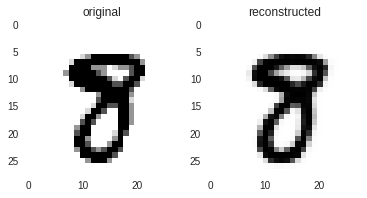

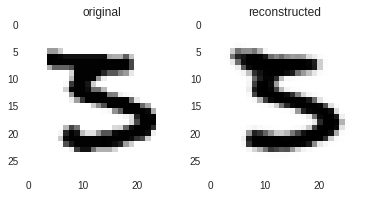

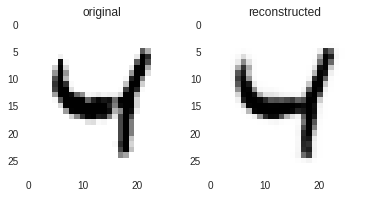

In [0]:
#@title Reconstruction test
model.eval()
for i in range(3):
  with torch.no_grad():
    inp = testset[np.random.randint(0,1000)][0].to(device)
    out = model(inp).squeeze(0).squeeze(0)
    plt.subplot(121)
    plt.imshow(inp.squeeze(0).squeeze(0).cpu().numpy(),interpolation="none")
    plt.grid()
    plt.title("original")
    plt.subplot(122)
    plt.imshow(out.cpu().numpy(),interpolation="none")
    plt.grid()
    plt.title("reconstructed")
    plt.show()

In [0]:
#@title Displaying 3D PCA latent space

def load_test_set(n):
  y = torch.cat([testset[i][0] for i in range(n)],0)
  z = [testset[i][1] for i in range(n)]
  return y,z

n = 10000

with torch.no_grad():
  x,label   = load_test_set(n)
  logvar,mu = model.encode(x.to(device))
  z         = model.sample(logvar,mu).cpu().numpy()

Rxx = np.cov(z.T)
[U,S,V] = np.linalg.svd(Rxx,full_matrices=True)
W = U[:,:3]

latent = z.dot(W)

sort = np.argsort(label)
label = np.asarray(label)[sort]
latent = latent[sort,:]

data = []

for i in range(10):
  data.append(go.Scatter3d(x=latent[label==i,0],
                     y =latent[label==i,1],
                     z =latent[label==i,2],
                     mode = 'markers',
                     marker = dict(size=2,
                                  color=i,
                                  colorscale="Jet",
                                  opacity=.8)))

fig = go.Figure(data=data)
plot(fig)

#for i in range(10):
#  plt.plot(latent[label==i,0],latent[label==i,1],"C{}.".format(i))
#plt.legend(range(10))
#plt.title("PC 1")
#plt.gcf().set_size_inches(8,8)
#plt.show()

#for i in range(10):
#  plt.plot(latent[label==i,2],latent[label==i,3],"C{}.".format(i))  
#plt.legend(range(10))
#plt.title("PC 2")
#plt.gcf().set_size_inches(8,8)
#plt.show()

'file:///content/temp-plot.html'

In [0]:
#@title Reconstruction from the 2D latent space
model.eval()
with torch.no_grad():
  #test = torch.tensor(np.asarray([-5,0]).dot(W.T),dtype=torch.float).to(device)
  test = torch.tensor(latent[3,:].dot(W.T),dtype=torch.float).to(device)
  img  = model.decode(test.unsqueeze(0)).squeeze(0).squeeze(0)
  plt.imshow(img.cpu().numpy())
  plt.grid()
  plt.show()

In [0]:
#@title Animation
!rm -r /tmp/output
!mkdir /tmp/output
x = np.linspace(0,2*np.pi,200)
for i in range(200):
  with torch.no_grad():
    test = torch.tensor(np.asarray([5*np.cos(x[i]),5*np.sin(x[i])]).dot(W.T),dtype=torch.float).to(device)
    #test = torch.tensor(latent[3,:].dot(W.T),dtype=torch.float).to(device)
    img  = model.decode(test.unsqueeze(0)).squeeze(0).squeeze(0)
    plt.imshow(img.cpu().numpy(),interpolation="none")
    plt.grid()
    #plt.savefig("/tmp/output/img_{:03d}.jpg".format(i))
    plt.show()
!cd /tmp/ && zip image.zip /tmp/output/*.jpg
from google.colab import files

rm: cannot remove '/tmp/output': No such file or directory


ValueError: ignored

In [0]:
with torch.no_grad():
  z = model.sample(*model.encode(minibatch)).cpu().numpy()
  
print("Minibatch var  = %f" % np.var(z))
print("Minibatch mean = %f" % np.mean(z))

In [0]:
files.download('/tmp/image.zip')

In [0]:
#@title Interpolation
y,img = load_test_set(2)
n = 20
x = torch.linspace(0,1,n).to(device)
z = model.sample(*model.encode(y.to(device)))


model.eval()
with torch.no_grad():
  for i in range(n):
    z_i = (z[0]*x[i] + z[1]*(1-x[i])).unsqueeze(0)
    img = model.decode(z_i).cpu().numpy().reshape([28,28])
    plt.imshow(img)
    plt.grid()
    plt.savefig("{:03d}.png".format(i))
    plt.show()

In [0]:
img.shape

In [0]:
!zip image.zip *.png